In [ ]:
# !/usr/bin/python3
# q-array: [charge_val, r, theta, phi]

#Unit system: e = hbar = 4*pi*epsilon = mass of electron = 1
"""Potenial improvements:
1. use symmetry !!!!,
2. trace perturbed orbitals
3. electric potential function still in natural unit
"""

# Imports
import numpy as np
from numpy import *
import matplotlib
from matplotlib import pyplot as plt
import math
import scipy
import scipy.special as sp
from scipy.special import sph_harm, roots_legendre
from scipy import integrate
from scipy.integrate import tplquad
from joblib import Parallel, delayed
from numpy.polynomial.legendre import leggauss

In [ ]:
### Basic constants, potential and eigen functions
a0 = 1    # reduced Bohr radius set to 1
im = complex(0, 1)   # imaginary number
eps = np.finfo(float).eps   # a small quantity to avoid division by zero
e = 1.60217663e-19  # electron charge
hbar = 1.0545718e-34    # reduced planck's constant
me = 9.1093837e-31  # mass of electron
epsilon = 8.854e-12     # dielectric constant of vacuum




def inter_potential(r, theta, phi, q_array):
    """The potential at (r, theta, phi) generated by a single charge in q_array
    
    Args:
        r (float): Radial distance
        theta (float): Polar angle
        phi (float): Azimuthal angle
        q_array (list): [charge, r_q, theta_q, phi_q] for a single charge
        
    Returns:
        float: Electrostatic potential value at point (r, theta, phi)
    """

    rq = q_array[1]
    thetaq = q_array[2]
    phiq = q_array[3]
    
    # xyz coordinates of charge
    xq = rq * np.sin(thetaq) * np.cos(phiq)
    yq = rq * np.sin(thetaq) * np.sin(phiq)
    zq = rq * np.cos(thetaq)

    # xyz coordinates of observation point 
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    # distance and potential value
    """Units to be adjusted"""
    d = np.sqrt((xq-x)**2 + (yq-y)**2 + (zq-z)**2)
    
    return -q_array[0] / d


def total_potential(r, theta, phi, charge_arrays):
    """Total potential generated by all charges
    
    Args:
        r (float): Radial distance
        theta (float): Polar angle
        phi (float): Azimuthal angle
        charge_arrays (list): List of charge arrays [charge, r, theta, phi]
        
    Returns:
        float: Sum of potentials from all charges
    """

    Vtot = 0
    for q in charge_arrays:
        Vtot +=  inter_potential(r, theta, phi, q)
    return Vtot


def find_eigenstates_polar(Zeff, n, l, m):
    """Hydrogenic wavefunction in spherical coordinates
    
    Args:
        Zeff (float): Effective atomic charge 
        n (int): Principal quantum number
        l (int): Angular quantum number
        m (int): Magnetic quantum number
        
    Returns:
        function: Wavefunction psi_nlm(r, theta, phi)
    """

    if n <= l:
        raise ValueError(f"Principle quantum number n must be greater than l, got n={n}, l={l}")
    
    if n-l-1 < 0:
        raise ValueError(f"n-l-1 must be non-negative, got n={n}, l={l}")
    
    if l < m or m < -l:
        raise ValueError(f"l must be larger or equal to abs(m), got l={l}, m={m}")

    def Y(theta, phi):
        # angular equation, but real valued
        if m == 0:
            return np.real(sph_harm(m, l, phi, theta))
        elif m < 0:
            return np.real(im/np.sqrt(2) * (sph_harm(m, l, phi, theta) - (-1)**m * sph_harm(-m, l, phi, theta)))
        else:
            return np.real(1/np.sqrt(2) * (sph_harm(-m, l, phi, theta) + (-1)**m * sph_harm(m, l, phi, theta)))
        #return sph_harm(m, l, phi, theta)

    def R(r):
        # radial equation
        laguerre = sp.genlaguerre(n-l-1, 2*l+1)
        rho = 2 * Zeff * r / (n * a0)
        numerator = (2*Zeff/(n*a0))**3 * sp.factorial(n-l-1)
        denominator = 2 * n * sp.factorial(n+l)
        norm_factor = np.sqrt(numerator / denominator)
        return norm_factor * np.exp(-rho/2) * rho**l * laguerre(rho)

    def eigenfunction(r, theta, phi):
        # final eigen function
        return Y(theta, phi) * R(r)

    return eigenfunction


def find_eigenstates_cart(Zeff, n, l, m):
    """return wave function in cartesian input"""
    def eigenfunction(x, y, z):
        r = np.sqrt(x**2 + y**2 + z**2)
        theta = np.arccos(z/(r+eps))
        phi = np.arctan2(y+eps, x)
        return find_eigenstates_polar(Zeff, n, l, m)(r, theta, phi)
    return eigenfunction


def radial_sampler(Zeff, n, Nr):
    # quantify decay of radial function
    r_peak = n**2 / Zeff
    r_max = 5 * r_peak

    # generate non-uniform sampling by logarithmic scale
    r_min = 1e-2
    log_r = np.linspace(np.log(r_min), np.log(r_max), Nr)
    r_vals = np.exp(log_r)

    return r_max, r_vals


def energy_levels(Zeff, n, eigen_val_array):
    """Compute perturbed energy levels
    
    Args:
        Zeff (float): Effective atomic number
        n (int): Principal quantum number
        eigen_val_array (array): Eigenvalues from perturbation matrix
        
    Returns:
        array: Array of [m, energy] pairs for each perturbed orbital
    """

    l = int((len(eigen_val_array)-1)/2)   # original degeneracy = 2*l+1
    E0 = -(1/2) * Zeff**2 / n**2    # zero-th order enregy
    result = np.zeros((len(eigen_val_array), 2))
    for m in range(-l, l+1):
        result[m+l] = [m, eigen_val_array[m+l] + E0]
    return result
    ### ISSUE: the order of splitting is not gauranteed


def E_recov_unit(E_reduced):
    """convert the energy in natural unit system to eV"""
    abohr = 4 * np.pi * epsilon * hbar**2 / (me * e**2)    # bhor radius
    return (1/e) * (e**2 / (4*np.pi*epsilon)) / abohr * E_reduced


In [ ]:
### Vectorizd perturbation matrix computation
def create_spherical_grid(Zeff, n, Nr=50, Ntheta=50, Nphi=50):
    """Create 3D spherical grid for integration
    
    Args:
        Zeff (float): Effective atomic number
        n (int): Principal quantum number
        Nr (int): Radial resolution
        Ntheta (int): Theta resolution
        Nphi (int): Phi resolution
        
    Returns:
        tuple: Grid arrays and coordinate vectors (r, theta, phi, r_vals, theta_vals, phi_vals)
    """

    # use radial_sampler to improve accuracy
    r_max, r_vals = radial_sampler(Zeff, n, Nr)
    r_vals = np.linspace(0, r_max, Nr)

    # uniform sampling for theta
    theta_vals = np.linspace(0, np.pi, Ntheta)

    # uniform sampling for phi
    phi_vals = np.linspace(0, 2*np.pi, Nphi)
    r, theta, phi = np.meshgrid(r_vals, theta_vals, phi_vals, indexing='ij')
    return r, theta, phi, r_vals, theta_vals, phi_vals


def precomp_eigenfunc_grid(Zeff, n, l, r, theta, phi):
    """Precompute eigenfunction values on grid
    
    Args:
        Zeff (float): Effective atomic number
        n (int): Principal quantum number
        l (int): Angular quantum number
        r (array): Radial grid
        theta (array): Theta grid
        phi (array): Phi grid
        
    Returns:
        array: Stacked array of wavefunctions for all m values
    """

    # use list so that arrays don't get expanded when appending
    eigenfunction_vals = []
    for m in range(-l, l+1):
        psi_func = find_eigenstates_polar(Zeff, n, l, m)
        psi_vals = psi_func(r, theta, phi)
        eigenfunction_vals.append(psi_vals)
    # stacking the array to become (2l+1) 3-D arrays
    return np.stack(eigenfunction_vals, axis=0)

#unnecessary function
def precomp_potential_grid(r, theta, phi, charge_arrays):
    """pre setting up values of potential on the grid"""
    return total_potential(r, theta, phi, charge_arrays)


def compute_matrix_element_grid(i, j, eigen_states, V_grid, r, theta, r_vals, theta_vals, phi_vals):
    """Compute matrix element <i|V|j> using grid integration
    
    Args:
        i (int): Index for bra state
        j (int): Index for ket state
        eigen_states (array): Precomputed wavefunctions
        V_grid (array): Precomputed potential
        r (array): Radial grid
        theta (array): Theta grid
        r_vals (array): Radial coordinate vector
        theta_vals (array): Theta coordinate vector
        phi_vals (array): Phi coordinate vector
        
    Returns:
        tuple: (i, j, integral_value)
    """

    # finite difference
    dr = np.diff(r_vals)
    dr = np.append(dr, dr[-1])
    dtheta = np.diff(theta_vals)
    dtheta = np.append(dtheta, dtheta[-1])
    dphi = np.diff(phi_vals)
    dphi = np.append(dphi, dphi[-1])

    # differential elements grid
    dr, dtheta, dphi = np.meshgrid(dr, dtheta, dphi, indexing='ij')

    weights = r**2 * np.sin(theta)

    integrand = eigen_states[i] * V_grid * eigen_states[j] * weights * dr * dtheta * dphi
    integral = np.sum(integrand)          # summing up elements 
    return i, j, integral


def perturbation_grid(eigen_states, V_grid, r, theta, r_vals, theta_vals, phi_vals, n_core):
    """Compute perturbation matrix in parallel
    
    Args:
        eigen_states (array): Precomputed wavefunctions
        V_grid (array): Precomputed potential
        r (array): Radial grid
        theta (array): Theta grid
        r_vals (array): Radial coordinate vector
        theta_vals (array): Theta coordinate vector
        phi_vals (array): Phi coordinate vector
        n_core (int): Number of cores for parallel computation
        
    Returns:
        tuple: (perturbation_matrix, eigenvalues, eigenvectors)
    """

    N = len(eigen_states)
    perturbation_matrix = np.zeros((N, N))

    # Generate upper triangle index pairs (i<=j)
    index_pairs = [(i, j) for i in range(N) for j in range(i, N)]

    # joblib for parallellize computation
    results = Parallel(n_jobs=n_core, verbose=10)(
        delayed(compute_matrix_element_grid)(i, j, eigen_states, V_grid, r, theta, r_vals, theta_vals, phi_vals)
        for i, j in index_pairs
    )

    # Fill the rest of the matrix
    for i, j, vals in results:
        perturbation_matrix[i, j] = vals
        if i != j:
            perturbation_matrix[j, i] = vals
    
    # Diagonalizing the perturbation matrix
    eigen_vals, eigen_vecs = np.linalg.eig(perturbation_matrix)
    return perturbation_matrix, eigen_vals, eigen_vecs


def pointc_grid(Zeff, n, l, charge_arrays, n_core, Nr=50, Ntheta=50, Nphi=50):
    """Main function for grid-based crystal field calculation
    
    Args:
        Zeff (float): Effective atomic number
        n (int): Principal quantum number
        l (int): Angular quantum number
        charge_arrays (list): List of charge configurations
        n_core (int): Number of cores for parallel computation
        Nr (int): Radial resolution
        Ntheta (int): Theta resolution
        Nphi (int): Phi resolution
        
    Returns:
        tuple: Perturbation results (matrix, eigenvalues, eigenvectors)
    """
    r, theta, phi, r_vals, theta_vals, phi_vals = create_spherical_grid(Zeff, n, Nr, Ntheta, Nphi)
    eigen_states = precomp_eigenfunc_grid(Zeff, n, l, r, theta, phi)
    V_grid = precomp_potential_grid(r, theta, phi, charge_arrays)
    return perturbation_grid(eigen_states, V_grid, r, theta, r_vals, theta_vals, phi_vals, n_core)


In [4]:
### Scalar perturbation matrix calculation
def compute_matrix_element(i, j, eigen_states, Vfunction, r_max):
    """compute perturbation matrix element Vij"""
    def integrand(r, theta, phi):
        phi_i = eigen_states[i](r, theta, phi)
        phi_j = eigen_states[j](r, theta, phi)
        V = Vfunction(r, theta, phi)
        return phi_i * V * phi_j * r**2 * np.sin(theta)
    
    # IMPORTANT: integration sequent different for nquad and tplquad, r first for nquad, phi first for tplquad
    limits = [(0, r_max), (0, np.pi), (0, 2*np.pi)]
    val, _ = integrate.nquad(integrand, limits, opts={"epsabs": 1e-6, "epsrel": 1e-4})
    return i, j, val


def perturbation(eigen_states, Vfunction, r_max, n_core):
    """the perturbed energies using degenerate perturbation theory"""
    # eigen_states[i] is a function of r, theta, phi
    # Vfunction is also a function of r, theta, phi
    N = len(eigen_states)
    perturbation_matrix= np.zeros((N, N))
    
    # Generate upper triangle index pairs (i <= j)
    index_pairs = [(i, j) for i in range(N) for j in range(i, N)]

    # joblib for parallellize computation
    results = Parallel(n_jobs=n_core, verbose=10)(
        delayed(compute_matrix_element)(i, j, eigen_states, Vfunction, r_max)
        for i, j in index_pairs
    )

    # Fill in the rest of matrix
    for i, j, val in results:
        perturbation_matrix[i, j] = val
        if i != j:
            perturbation_matrix[j, i] = val

    # Diagonalizing to find splitting in energy
    perturbed_energies, eigen_vectors= np.linalg.eig(perturbation_matrix)
    return perturbation_matrix, perturbed_energies, eigen_vectors


def pointc(Zeff, n, l, charge_arrays, r_max, n_core):
    """return perturbation matrix, its eigen value array, and eigen vectors, giving the charge distribution"""
    def Vfunction(r, theta, phi):
        return total_potential(r, theta, phi, charge_arrays)
    eigen_states = []
    for m in range(-l, l+1):
        eigen_states.append(find_eigenstates_polar(Zeff, n, l, m))
    return perturbation(eigen_states, Vfunction, r_max, n_core)




In [160]:
# testing energy splitting pattern of d-orbitals
# correspondence for 3d orbitals:
# m=-2 >> 3dxy
# m=-1 >> 3dyz
# m=0 >> 3dz^2
# m=1 >> 3dxz
# m=2 >> 3dx^2-y^2

# octahedral symmetry
# charge = -4e, distance = 2*a0
q1 = [-4, 2, 0, 0]
q2 = [-4, 2, np.pi/2, 0]
q3 = [-4, 2, np.pi/2, np.pi/2]
q4 = [-4, 2, np.pi/2, np.pi]
q5 = [-4, 2, np.pi/2, np.pi*3/2]
q6 = [-4, 2, np.pi, 0]
oth_charge_array = [q1, q2, q3, q4, q5, q6]

# simulating an Fe ion in center, valence Zeff = 11.18
perturbation_matrix, perturbed_energies, eigen_vectors = pointc_grid(Zeff=11.18, n=3, l=2, \
                                                                charge_arrays=oth_charge_array,  n_core=15, Nr=100, Ntheta=250, Nphi=250)


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:    2.0s remaining:   13.6s
[Parallel(n_jobs=15)]: Done   4 out of  15 | elapsed:    2.0s remaining:    5.7s
[Parallel(n_jobs=15)]: Done   6 out of  15 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=15)]: Done   8 out of  15 | elapsed:    2.1s remaining:    1.8s
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:    2.1s remaining:    1.0s
[Parallel(n_jobs=15)]: Done  12 out of  15 | elapsed:    2.2s remaining:    0.5s
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:    2.2s finished


In [158]:
# Normalization test
def norm_test(Zeff, n, l, Nr, Ntheta, Nphi):
    r, theta, phi, r_vals, theta_vals, phi_vals = create_spherical_grid(Zeff, n, Nr, Ntheta, Nphi)
    eigen_function = precomp_eigenfunc_grid(Zeff, n, l, r, theta, phi)
    V_grid = 1
    return compute_matrix_element_grid(0, 0, eigen_function, V_grid, r, theta, r_vals, theta_vals, phi_vals)
norm_test(11, 3, 2, 100, 200, 200)


(0, 0, 0.9999998960562693)

In [77]:
# normalization test for compute_matrix_element function
charge_arrays = [[1, 1, 0, 0]]
def V(r, theta, phi):
    return 1#total_potential(r, theta, phi, charge_arrays)
eigen_states= [find_eigenstates_polar(2, 3, 1, 1)]
compute_matrix_element(0, 0, eigen_states, V, 100)

(0, 0, 1.000000000015035)

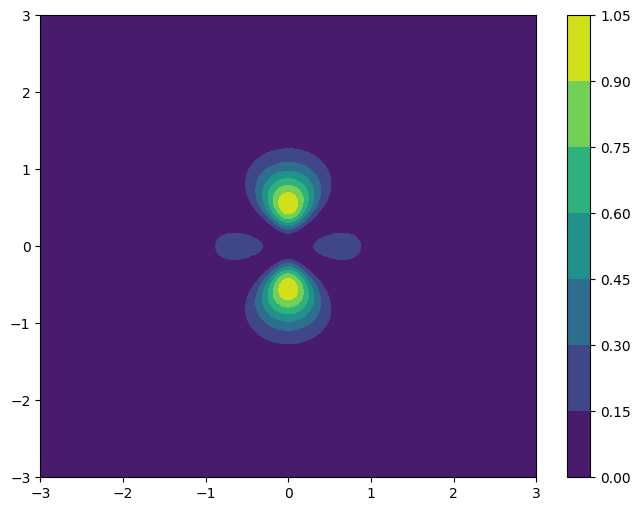

In [ ]:
# plotting the hydrogen wave function
# correspondence for 3d orbitals:
# m=-2 >> 3dxy
# m=-1 >> 3dyz
# m=0 >> 3dz^2
# m=1 >> 3dxz
# m=2 >> 3dx^2-y^2

grid_extent = 3
grid_resolution= 680
x = y = np.linspace(-grid_extent, grid_extent, grid_resolution)
x, y = np.meshgrid(x, y)
eps = np.finfo(float).eps
wfc = np.array(find_eigenstates_cart(11, 3, 2, 0)(np.ravel(x), 0, np.ravel(y))**2)
value_grid = wfc.reshape(x.shape)
fig, ax = plt.subplots(figsize=(8, 6))
contour = plt.contourf(x, y, value_grid)
plt.colorbar(contour)